In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

## Improving on OLS

__Ordinary Least Squares:__

$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2$
- Model fit determined by minimzing the sum of squared differences between predicted and actual values
- OLS cost function optimizes variance explained in the training set
- Can get more accurate predictions by modifying this cost function, eg. ridge & lasso

## Ridge regression
$\sum_{i=1}^n(y_i(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p\beta^2_j$
- Adds $\lambda\sum_{j=1}^p\beta^2_j$ to the OLS cost function
- Represent the sum of the square of all model coefficients (1 through $p$), multiplied by regularization parameter $\lambda$
- Imposes a penalty for large coefficients
- As $\lambda$ increases, penalty increases, and solution minimizing cost function will have smaller coefficient estimates

__Note:__ in sklearn regularization parameter $\lambda$ is $\alpha$ instead since lambda is already a defined function

As models become increasingly complex and features become more multicolinear, coefficients arrived at by OLS become increasingly large. This indicates the model is overfitting by incorporating too much variance from the dataset

In [2]:
#load data, drop index column and missing data columns
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

#recode strings to numeric
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes',1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

#define training and test sizes
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

#set up regression model to predict defaults using all other
#variables as features
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1,1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#store parameter estimates
origparams = np.append(regr1.coef_, regr1.intercept_)

#make new features to capture potential quadratic and cubic relationships
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

#re-run model with new features
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

#store new parameter estimates for the same features
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter estimates for the same predictors for the small model '
     'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.5738784962717032

R-squared complex model:
0.5739734452059888

Parameter estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.867]
 [-0.001 553434.569]]


R-squared barely increased with the complex model, inflation in parameters (eg. last line) indicates gain is due to overfitting.

In [3]:
#run models on test set
#simple model with smaller coefficients
Y_test = df_test['income'].values.reshape(-1,1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

#complex model with larger coefficients
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

X_test2 = df_test.loc[:,~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.5630697922503316

R-squared complex model:
0.5630239527355649


__Result:__ more complex model is fitting worse

In [4]:
#fit ridge regression
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0,0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.5738739164402877
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613304

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


Difference in magnitude for parameters in training set is much smaller

In [5]:
#check fit on test data
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.5631088763076704
0.5631804323931054


Model works slightly better on both training and test sets. While differences here are small, much larger differences can happen. Ridge regression is good to use when there are many correlated parameters, or when parameter estimates inflate as r-squared goes up (overfitting)

## Regularization Parameter: Ridge

- $\lambda$ can take any value greater than 0
- Choose optimal $\lambda$ through cross-validation, looking for consistency between train and test sets

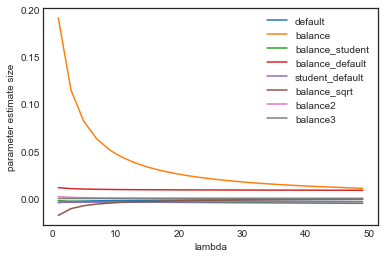

In [6]:
#store estimates
estimates = np.append(ridgeregrBig.coef_, [10])

#store legend information
labels = []

#run model for many alphas (regularization paramaters)
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

#make data pretty
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

#leave out 'student' variable, high values throws off plot's scale
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

#plot a line for each parameter
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('parameter estimate size')
plt.legend(labels)
plt.show()